In [1]:
import pandas as pd
import os
from tqdm import tqdm

# Define the directory where your CSV files are located
folder_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Premier League 2024-2025/"  # Replace with your folder path
output_file = "Coach 2024-2025.xlsx"  # Output file path

# Define goalkeeper-related actions
gk_actions = {
    'Goalkick': 124,
    'GK throw': 123,
    'Parried Safe': 173,
    'Parried Danger': 174,
    'Fingertip': 175,
    'Caught': 176,
    'Collected': 177,
    'Standing Goalkeeper': 178,
    'Diving': 179,
    'Stooping': 180,
    'Reaching': 181,
    'Hands': 182,
    'Feet': 183,
    'Scored': 186,
    'Saved': 187,
    'Missed': 188
}

# Create a list to store all results
all_results = []

# Loop through all CSV files in the folder
for file_name in tqdm(os.listdir(folder_path), desc="Processing Files"):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Identify columns with '/qualifierId'
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        # Initialize 'endX' and 'endY' columns
        df['endX'] = 0.0
        df['endY'] = 0.0

        # Map qualifierId to corresponding value columns
        qualifier_value_cols = {int(col.split('/')[1]): col for col in df.columns if 'qualifier' in col and 'value' in col}

        # Process rows efficiently
        for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
            for j, type_col in enumerate(type_cols):
                if row[type_col] == 140:
                    endx_col = qualifier_value_cols.get(j)
                    if endx_col:
                        df.at[index, 'endX'] = row[endx_col]
                elif row[type_col] == 141:
                    endy_col = qualifier_value_cols.get(j)
                    if endy_col:
                        df.at[index, 'endY'] = row[endy_col]

        # Initialize new columns for different types of set pieces
        df['Set Piece'] = 0
        df['From Corner'] = 0
        df['Free Kick'] = 0
        df['Throw In'] = 0

        # Process rows efficiently to flag set pieces
        for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows for Set Pieces"):
            for j, type_col in enumerate(type_cols):
                qualifier = row[type_col]
                
                # Check for the 'qualifierId' values
                if qualifier == 24:
                    df.at[index, 'Set Piece'] = 1
                elif qualifier == 25:
                    df.at[index, 'From Corner'] = 1
                elif qualifier == 26:
                    df.at[index, 'Free Kick'] = 1
                elif qualifier == 160:
                    df.at[index, 'Throw In'] = 1

        # Now assign Set Piece metric for the rows where 'Set Piece' is true or 'From Corner' or 'Free Kick' or 'Throw In'
        df['Set Piece'] = df.apply(
            lambda row: 1 if row['typeId'] in [13, 14, 15, 16] and 
                        (row['Set Piece'] == 1 or row['From Corner'] == 1 or 
                         row['Free Kick'] == 1 or row['Throw In'] == 1) else 0,
            axis=1
        )

        # Convert columns to numeric
        df[['x', 'y', 'endX', 'endY']] = df[['x', 'y', 'endX', 'endY']].apply(pd.to_numeric, errors='coerce')

        # Define event-based metrics
        df_long_balls = df[(df['typeId'] == 1) & (df['x'] < 30) & (df['endX'] > 50)]
        df_deep_circulations = df[(df['typeId'] == 1) & (df['x'].between(30, 60)) & (df['y'].between(22, 78)) & (df['endX'].between(30, 60))]
        df_wing_play = df[(df['typeId'] == 1) & (df['x'].between(30, 60)) & (df['y'].between(22, 78)) & ((df['endY'] < 22) | (df['endY'] > 78))]
        df_final_third = df[(df['typeId'] == 1) & (df['x'] > 70)]
        df_crossing = df[(df['typeId'] == 1) & (df['x'] > 50) & ((df['y'] <= 22) | (df['y'] >= 78)) & (df['endY'].between(22, 78)) & (df['endX'] > 85)]
        df_opposition_passes = df[df['typeId'] == 1]
        df_defensive_actions = df[df['typeId'].isin([7, 8])]

        # Aggregate counts
        long_balls_count = df_long_balls.groupby('contestantId').size().reset_index(name='Long balls')
        deep_circulations_count = df_deep_circulations.groupby('contestantId').size().reset_index(name='Deep circulation')
        wing_play_count = df_wing_play.groupby('contestantId').size().reset_index(name='Wing play')
        final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')
        crossing_count = df_crossing.groupby('contestantId').size().reset_index(name='Crossing')

        # Territory calculation
        total_final_third_passes = df_final_third.shape[0]
        final_third_count['Territory'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

        # Low Block calculation
        df['Low Block'] = df.apply(lambda row: 1 if row['typeId'] in [7, 8, 12] and row['x'] < 25 else 0, axis=1)
        total_defensive_actions = df[df['typeId'].isin([7, 8, 12])].shape[0]
        low_block_count = df.groupby('contestantId')['Low Block'].sum().reset_index()
        low_block_count['Low Block'] = (low_block_count['Low Block'] / total_defensive_actions) * 100

        # Counters calculation
        def find_counters(df):
            counters = []
            for i in range(len(df)):
                if df.iloc[i]['typeId'] == 49 and df.iloc[i]['x'] < 50:
                    found_counter = any(df.iloc[j]['typeId'] == 1 and df.iloc[j]['x'] > 70 for j in range(i + 1, min(i + 4, len(df))))
                    counters.append(1 if found_counter else 0)
                else:
                    counters.append(0)
            return counters

        df['Counters'] = find_counters(df)
        counters_count = df.groupby('contestantId')['Counters'].sum().reset_index()

        # Set Piece calculation (already done above for each row)

        # Merge all metrics into the final result
        result = long_balls_count.merge(deep_circulations_count, on='contestantId', how='left').fillna(0)
        result = result.merge(wing_play_count, on='contestantId', how='left').fillna(0)
        result = result.merge(final_third_count[['contestantId', 'Territory']], on='contestantId', how='left').fillna(0)
        result = result.merge(crossing_count, on='contestantId', how='left').fillna(0)
        result = result.merge(low_block_count, on='contestantId', how='left').fillna(0)
        result = result.merge(counters_count, on='contestantId', how='left').fillna(0)
        result = result.merge(df.groupby('contestantId')['Set Piece'].sum().reset_index(), on='contestantId', how='left').fillna(0)

        # High Press calculation
        total_opposition_passes = df_opposition_passes.shape[0]
        result['High Press'] = result.apply(lambda row: (total_opposition_passes - row.get('Opposition passes', 0)) / row.get('Defensive actions', 1), axis=1)

        # Ensure integer types
        int_cols = ['Long balls', 'Deep circulation', 'Wing play', 'Crossing', 'Counters', 'Set Piece']
        result[int_cols] = result[int_cols].astype(int)

        # --- Step for Goalkeeper Actions ---
        # Add GK action columns (default 0)
        for action in gk_actions.keys():
            df[action] = 0

        # Identify type columns containing '/qualifierId'
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        # Step 1: Identify goalkeepers based on specific qualifiers
        for i in range(len(df)):
            for col in type_cols:
                qualifier_value = df.at[i, col]
                for action, value in gk_actions.items():
                    if qualifier_value == value:
                        df.at[i, action] = 1

        # Step 2: Calculate GK action count per player
        df['GK_Action_Count'] = df[list(gk_actions.keys())].sum(axis=1)

        # Step 3: Identify one goalkeeper per contestantId (team)
        gk_candidates = df.groupby(['contestantId', 'playerName'])['GK_Action_Count'].sum().reset_index()
        gk_best_per_team = gk_candidates.sort_values(['contestantId', 'GK_Action_Count'], ascending=[True, False])
        gk_best_per_team = gk_best_per_team.groupby('contestantId').first().reset_index()

        # Step 4: Merge with main df to get all passes (typeId == 1) for selected GKs
        gk_passes = df.merge(gk_best_per_team, on=['contestantId', 'playerName'], how='inner')
        gk_passes = gk_passes[gk_passes['typeId'] == 1]

        # Step 5: Count passes per GK per contestantId
        gk_pass_count = gk_passes.groupby(['contestantId', 'playerName']).size().reset_index(name='Pass_Count')

        # Step 6: Calculate the total number of passes in the dataset
        total_passes = len(df[df['typeId'] == 1])

        # Step 7: Calculate the percentage of passes made by each goalkeeper (now renamed to GK Build Up)
        gk_pass_count['GK Build Up'] = (gk_pass_count['Pass_Count'] / total_passes) * 100

        # Merge goalkeeper stats into the final result
        result = result.merge(gk_pass_count[['contestantId', 'playerName', 'Pass_Count', 'GK Build Up']], 
                              on='contestantId', how='left')

        all_results.append(result)

# Combine all results
final_result = pd.concat(all_results, ignore_index=True)

# Calculate per-contestant averages
averages_per_contestant = final_result.groupby('contestantId').mean()

# Save to Excel
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, sheet_name='Aggregated Data', index=False)
    averages_per_contestant.to_excel(writer, sheet_name='Averages per Contestant', index=True)

print(f"Processing completed. Results saved to {output_file}.")


Processing Rows: 100%|████████████████████| 1806/1806 [00:00<00:00, 2248.45it/s]

Processing Rows: 100%|████████████████████| 1686/1686 [00:00<00:00, 2737.68it/s]

Processing Rows: 100%|████████████████████| 1641/1641 [00:00<00:00, 2818.28it/s]

Processing Rows: 100%|████████████████████| 1788/1788 [00:00<00:00, 2854.30it/s]

Processing Rows: 100%|████████████████████| 1746/1746 [00:00<00:00, 2429.57it/s]

Processing Rows: 100%|████████████████████| 1700/1700 [00:00<00:00, 2151.13it/s]

Processing Rows: 100%|████████████████████| 1595/1595 [00:00<00:00, 2622.17it/s]

Processing Rows: 100%|████████████████████| 1685/1685 [00:00<00:00, 2796.28it/s]

Processing Rows:   0%|                                 | 0/1632 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1632/1632 [00:00<00:00, 3139.43it/s]

Processing Rows: 100%|████████████████████| 1760/1760 [00:00<00:00, 3103.63it/s]

Processing Rows: 100%|████████████████████| 1797/1797 [00:00<00:00, 3630.96it/s]

Processing Rows: 100%|████████████████████| 1769/1769 [00:00<00:00, 3571.03it/s]

Processing Rows: 100%|████████████████████| 1665/1665 [00:00<00:00, 3770.65it/s]

Processing Rows: 100%|████████████████████| 1774/1774 [00:00<00:00, 3548.33it/s]

Processing Rows: 100%|████████████████████| 1919/1919 [00:00<00:00, 3146.56it/s]

Processing Rows: 100%|████████████████████| 1708/1708 [00:00<00:00, 3531.90it/s]

Processing Rows: 100%|████████████████████| 1756/1756 [00:00<00:00, 3020.23it/s]

Processing Rows: 100%|████████████████████| 1629/1629 [00:00<00:00, 3390.70it/s]

Processing Rows:   0%|                                 | 0/1708 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1708/1708 [00:00<00:00, 3572.51it/s]

Processing Rows: 100%|████████████████████| 1734/1734 [00:00<00:00, 3468.86it/s]

Processing Rows: 100%|████████████████████| 1648/1648 [00:00<00:00, 3629.22it/s]

Processing Rows: 100%|████████████████████| 1817/1817 [00:00<00:00, 3800.08it/s]

Processing Rows: 100%|████████████████████| 1715/1715 [00:00<00:00, 3335.25it/s]

Processing Rows: 100%|████████████████████| 1708/1708 [00:00<00:00, 3233.49it/s]

Processing Rows: 100%|████████████████████| 1663/1663 [00:00<00:00, 3077.02it/s]

Processing Rows: 100%|████████████████████| 1705/1705 [00:00<00:00, 3753.30it/s]

Processing Rows: 100%|████████████████████| 1818/1818 [00:00<00:00, 3425.74it/s]

Processing Rows: 100%|████████████████████| 1711/1711 [00:00<00:00, 3180.68it/s]

Processing Rows:  21%|████▍                | 342/1602 [00:00<00:00, 3417.20it/s]


Processing Rows: 100%|████████████████████| 1602/1602 [00:00<00:00, 3404.45it/s]

Processing Rows: 100%|████████████████████| 1803/1803 [00:00<00:00, 3522.94it/s]

Processing Rows: 100%|████████████████████| 1627/1627 [00:00<00:00, 2971.38it/s]

Processing Rows: 100%|████████████████████| 1814/1814 [00:00<00:00, 3260.95it/s]

Processing Rows: 100%|████████████████████| 1761/1761 [00:00<00:00, 3082.66it/s]

Processing Rows: 100%|████████████████████| 1782/1782 [00:00<00:00, 3493.36it/s]

Processing Rows: 100%|████████████████████| 1555/1555 [00:00<00:00, 2881.38it/s]

Processing Rows: 100%|████████████████████| 1769/1769 [00:00<00:00, 3156.01it/s]

Processing Rows: 100%|████████████████████| 1619/1619 [00:00<00:00, 3063.73it/s]

Processing Rows: 100%|████████████████████| 1681/1681 [00:00<00:00, 3554.96it/s]

Processing Rows for Set Pieces:   0%|                  | 0/1681 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1765/1765 [00:00<00:00, 3180.84it/s]

Processing Rows: 100%|████████████████████| 1680/1680 [00:00<00:00, 3523.65it/s]

Processing Rows: 100%|████████████████████| 1588/1588 [00:00<00:00, 2397.42it/s]

Processing Rows: 100%|████████████████████| 1742/1742 [00:00<00:00, 3505.36it/s]

Processing Rows: 100%|████████████████████| 1859/1859 [00:00<00:00, 3642.65it/s]

Processing Rows: 100%|████████████████████| 1658/1658 [00:00<00:00, 3782.14it/s]

Processing Rows: 100%|████████████████████| 1626/1626 [00:00<00:00, 3629.70it/s]

Processing Rows: 100%|████████████████████| 1846/1846 [00:00<00:00, 3695.89it/s]

Processing Rows: 100%|████████████████████| 1629/1629 [00:00<00:00, 2896.95it/s]

Processing Rows: 100%|████████████████████| 1758/1758 [00:00<00:00, 3050.51it/s]

Processing Rows for Set Pieces:   0%|                  | 0/1758 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1776/1776 [00:00<00:00, 3285.00it/s]

Processing Rows: 100%|████████████████████| 1730/1730 [00:00<00:00, 3336.31it/s]

Processing Rows: 100%|████████████████████| 1612/1612 [00:00<00:00, 3384.94it/s]

Processing Rows: 100%|████████████████████| 1674/1674 [00:00<00:00, 3466.08it/s]

Processing Rows: 100%|████████████████████| 1484/1484 [00:00<00:00, 3444.47it/s]

Processing Rows: 100%|████████████████████| 1736/1736 [00:00<00:00, 2546.42it/s]

Processing Rows: 100%|████████████████████| 1802/1802 [00:00<00:00, 3452.32it/s]

Processing Rows: 100%|████████████████████| 1639/1639 [00:00<00:00, 3416.32it/s]

Processing Rows: 100%|████████████████████| 1752/1752 [00:00<00:00, 3453.74it/s]

Processing Rows:  65%|████████████▉       | 1119/1722 [00:00<00:00, 3627.23it/s]


Processing Rows: 100%|████████████████████| 1722/1722 [00:00<00:00, 3633.19it/s]

Processing Rows: 100%|████████████████████| 1738/1738 [00:00<00:00, 3977.51it/s]

Processing Rows: 100%|████████████████████| 1711/1711 [00:00<00:00, 3277.53it/s]

Processing Rows: 100%|████████████████████| 1769/1769 [00:00<00:00, 3897.61it/s]

Processing Rows: 100%|████████████████████| 1710/1710 [00:00<00:00, 3771.46it/s]

Processing Rows: 100%|████████████████████| 1494/1494 [00:00<00:00, 3833.80it/s]

Processing Rows: 100%|████████████████████| 1891/1891 [00:00<00:00, 3208.06it/s]

Processing Rows: 100%|████████████████████| 1699/1699 [00:00<00:00, 3457.82it/s]

Processing Rows: 100%|████████████████████| 1774/1774 [00:00<00:00, 3577.20it/s]

Processing Rows: 100%|████████████████████| 1810/1810 [00:00<00:00, 3695.45it/s]

Processing Rows: 100%|████████████████████| 1622/1622 [00:00<00:00, 2997.38it/s]

Processing Files:  24%|█████▋                  | 68/288 [01:53<05:57,  1.62s/it]


Processing Rows: 100%|████████████████████| 1758/1758 [00:00<00:00, 3451.67it/s]

Processing Rows: 100%|████████████████████| 1621/1621 [00:00<00:00, 3596.17it/s]

Processing Rows: 100%|████████████████████| 1731/1731 [00:00<00:00, 3516.16it/s]

Processing Rows: 100%|████████████████████| 1764/1764 [00:00<00:00, 3717.03it/s]

Processing Rows: 100%|████████████████████| 1736/1736 [00:00<00:00, 2213.35it/s]

Processing Rows: 100%|████████████████████| 1722/1722 [00:00<00:00, 3118.36it/s]

Processing Rows: 100%|████████████████████| 1739/1739 [00:00<00:00, 3424.26it/s]

Processing Rows: 100%|████████████████████| 1723/1723 [00:00<00:00, 2952.07it/s]

Processing Rows: 100%|████████████████████| 1727/1727 [00:00<00:00, 3790.76it/s]

Processing Rows: 100%|████████████████████| 1724/1724 [00:00<00:00, 3850.21it/s]



Processing Rows: 100%|████████████████████| 1853/1853 [00:00<00:00, 3460.93it/s]

Processing Rows: 100%|████████████████████| 1666/1666 [00:00<00:00, 3168.31it/s]

Processing Rows: 100%|████████████████████| 1690/1690 [00:00<00:00, 3802.03it/s]

Processing Rows: 100%|████████████████████| 1610/1610 [00:00<00:00, 3507.61it/s]

Processing Rows: 100%|████████████████████| 1738/1738 [00:00<00:00, 3407.66it/s]

Processing Rows: 100%|████████████████████| 1795/1795 [00:00<00:00, 3005.18it/s]

Processing Rows: 100%|████████████████████| 1714/1714 [00:00<00:00, 3086.76it/s]

Processing Rows: 100%|████████████████████| 1725/1725 [00:00<00:00, 3107.10it/s]

Processing Rows: 100%|████████████████████| 1705/1705 [00:00<00:00, 2988.29it/s]

Processing Rows:  64%|████████████▊       | 1094/1704 [00:00<00:00, 3691.65it/s]


Processing Rows: 100%|████████████████████| 1704/1704 [00:00<00:00, 3561.24it/s]

Processing Rows: 100%|████████████████████| 1704/1704 [00:00<00:00, 3121.65it/s]

Processing Rows: 100%|████████████████████| 1782/1782 [00:00<00:00, 3614.39it/s]

Processing Rows: 100%|████████████████████| 1706/1706 [00:00<00:00, 3779.75it/s]

Processing Rows: 100%|████████████████████| 1681/1681 [00:00<00:00, 2680.49it/s]

Processing Rows: 100%|████████████████████| 1573/1573 [00:00<00:00, 3261.28it/s]

Processing Rows: 100%|████████████████████| 1543/1543 [00:00<00:00, 3654.86it/s]

Processing Rows: 100%|████████████████████| 1703/1703 [00:00<00:00, 3442.53it/s]

Processing Rows: 100%|████████████████████| 1620/1620 [00:00<00:00, 2998.11it/s]

Processing Rows: 100%|████████████████████| 1799/1799 [00:00<00:00, 3358.49it/s]

Processing Rows: 100%|████████████████████| 1739/1739 [00:00<00:00, 3240.91it/s]

Processing Rows for Set Pieces:   0%|                  | 0/1739 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1643/1643 [00:00<00:00, 3393.79it/s]

Processing Rows: 100%|████████████████████| 1731/1731 [00:00<00:00, 3333.07it/s]

Processing Rows: 100%|████████████████████| 1817/1817 [00:00<00:00, 3674.66it/s]

Processing Rows: 100%|████████████████████| 1774/1774 [00:00<00:00, 3206.19it/s]

Processing Rows: 100%|████████████████████| 1698/1698 [00:00<00:00, 3287.24it/s]

Processing Rows: 100%|████████████████████| 1736/1736 [00:00<00:00, 3457.58it/s]

Processing Rows: 100%|████████████████████| 1720/1720 [00:00<00:00, 3870.87it/s]

Processing Rows: 100%|████████████████████| 1823/1823 [00:00<00:00, 3911.90it/s]

Processing Rows: 100%|████████████████████| 1458/1458 [00:00<00:00, 3231.62it/s]

Processing Rows: 100%|████████████████████| 1698/1698 [00:00<00:00, 3590.23it/s]

Processing Files:  38%|████████▋              | 108/288 [02:57<04:38,  1.55s/it]


Processing Rows: 100%|████████████████████| 1590/1590 [00:00<00:00, 3387.62it/s]

Processing Rows: 100%|████████████████████| 1638/1638 [00:00<00:00, 3068.55it/s]

Processing Rows: 100%|████████████████████| 1629/1629 [00:00<00:00, 3665.68it/s]

Processing Rows: 100%|████████████████████| 1721/1721 [00:00<00:00, 2998.32it/s]

Processing Rows: 100%|████████████████████| 1693/1693 [00:00<00:00, 1830.68it/s]

Processing Rows: 100%|████████████████████| 1686/1686 [00:00<00:00, 3083.28it/s]

Processing Rows: 100%|████████████████████| 1680/1680 [00:00<00:00, 3239.12it/s]

Processing Rows: 100%|████████████████████| 1833/1833 [00:00<00:00, 3452.13it/s]

Processing Rows: 100%|████████████████████| 1687/1687 [00:00<00:00, 3432.63it/s]

Processing Rows: 100%|██████████████████████| 464/464 [00:00<00:00, 4715.50it/s]

Processing Rows for Set Pieces: 100%|███████| 464/464 [00:00<00:00, 6488.06it/s]


Processing Rows: 100%|████████████████████| 1843/1843 [00:00<00:00, 3787.97it/s]

Processing Rows: 100%|████████████████████| 1690/1690 [00:00<00:00, 3520.25it/s]

Processing Rows: 100%|████████████████████| 1684/1684 [00:00<00:00, 3159.72it/s]

Processing Rows: 100%|████████████████████| 1566/1566 [00:00<00:00, 3262.61it/s]

Processing Rows: 100%|████████████████████| 1860/1860 [00:00<00:00, 3138.10it/s]

Processing Rows: 100%|████████████████████| 1881/1881 [00:00<00:00, 3163.75it/s]

Processing Rows: 100%|████████████████████| 1577/1577 [00:00<00:00, 3689.93it/s]

Processing Rows: 100%|████████████████████| 1802/1802 [00:00<00:00, 3210.96it/s]

Processing Rows: 100%|████████████████████| 1703/1703 [00:00<00:00, 3598.52it/s]

Processing Rows: 100%|████████████████████| 1822/1822 [00:00<00:00, 2758.71it/s]

Processing Rows for Set Pieces:  27%|█▋    | 498/1822 [00:00<00:00, 4973.94it/s]


Processing Rows: 100%|████████████████████| 1713/1713 [00:00<00:00, 3338.50it/s]

Processing Rows: 100%|████████████████████| 1687/1687 [00:00<00:00, 3426.63it/s]

Processing Rows: 100%|████████████████████| 1683/1683 [00:00<00:00, 3935.61it/s]

Processing Rows: 100%|████████████████████| 1767/1767 [00:00<00:00, 3708.25it/s]

Processing Rows: 100%|████████████████████| 1688/1688 [00:00<00:00, 3263.42it/s]

Processing Rows: 100%|████████████████████| 1714/1714 [00:00<00:00, 3711.24it/s]

Processing Rows: 100%|████████████████████| 1546/1546 [00:00<00:00, 2828.59it/s]

Processing Rows: 100%|████████████████████| 1768/1768 [00:00<00:00, 3614.29it/s]

Processing Rows: 100%|████████████████████| 1721/1721 [00:00<00:00, 3926.16it/s]

Processing Rows: 100%|████████████████████| 1700/1700 [00:00<00:00, 2988.65it/s]

Processing Rows for Set Pieces: 100%|█████| 1700/1700 [00:00<00:00, 4476.53it/s]


Processing Rows: 100%|████████████████████| 1763/1763 [00:00<00:00, 3166.82it/s]

Processing Rows: 100%|████████████████████| 1644/1644 [00:00<00:00, 3407.51it/s]

Processing Rows: 100%|████████████████████| 1639/1639 [00:00<00:00, 3700.17it/s]

Processing Rows: 100%|████████████████████| 1700/1700 [00:00<00:00, 2995.53it/s]

Processing Rows: 100%|████████████████████| 1641/1641 [00:00<00:00, 3355.93it/s]

Processing Rows: 100%|████████████████████| 1625/1625 [00:00<00:00, 3595.39it/s]

Processing Rows: 100%|████████████████████| 1630/1630 [00:00<00:00, 3606.32it/s]

Processing Rows: 100%|████████████████████| 1698/1698 [00:00<00:00, 3392.70it/s]

Processing Rows: 100%|████████████████████| 1692/1692 [00:00<00:00, 3081.43it/s]

Processing Rows: 100%|████████████████████| 1693/1693 [00:00<00:00, 3402.67it/s]

Processing Rows for Set Pieces: 100%|█████| 1693/1693 [00:00<00:00, 6152.54it/s]


Processing Rows: 100%|████████████████████| 1670/1670 [00:00<00:00, 3596.32it/s]

Processing Rows: 100%|████████████████████| 1566/1566 [00:00<00:00, 3571.45it/s]

Processing Rows: 100%|████████████████████| 1711/1711 [00:00<00:00, 3491.64it/s]

Processing Rows: 100%|████████████████████| 1719/1719 [00:00<00:00, 3311.66it/s]

Processing Rows: 100%|████████████████████| 1715/1715 [00:00<00:00, 3964.72it/s]

Processing Rows: 100%|████████████████████| 1557/1557 [00:00<00:00, 3248.01it/s]

Processing Rows: 100%|████████████████████| 1676/1676 [00:00<00:00, 3504.56it/s]

Processing Rows: 100%|████████████████████| 1725/1725 [00:00<00:00, 3669.14it/s]

Processing Rows: 100%|████████████████████| 1584/1584 [00:00<00:00, 3019.15it/s]

Processing Rows: 100%|████████████████████| 1718/1718 [00:00<00:00, 3685.27it/s]

Processing Rows:  47%|█████████▉           | 838/1767 [00:00<00:00, 4048.61it/s]


Processing Rows: 100%|████████████████████| 1767/1767 [00:00<00:00, 3926.70it/s]

Processing Rows: 100%|████████████████████| 1646/1646 [00:00<00:00, 3510.24it/s]

Processing Rows: 100%|████████████████████| 1733/1733 [00:00<00:00, 3655.41it/s]

Processing Rows: 100%|████████████████████| 1553/1553 [00:00<00:00, 3471.84it/s]

Processing Rows: 100%|████████████████████| 1698/1698 [00:00<00:00, 3277.48it/s]

Processing Rows: 100%|████████████████████| 1702/1702 [00:00<00:00, 3208.74it/s]

Processing Rows: 100%|████████████████████| 1684/1684 [00:00<00:00, 3027.17it/s]

Processing Rows: 100%|████████████████████| 1669/1669 [00:00<00:00, 2265.60it/s]

Processing Rows: 100%|████████████████████| 1711/1711 [00:00<00:00, 3602.74it/s]

Processing Rows: 100%|████████████████████| 1720/1720 [00:00<00:00, 3390.00it/s]

Processing Rows:  43%|█████████            | 697/1619 [00:00<00:00, 3489.65it/s]


Processing Rows: 100%|████████████████████| 1619/1619 [00:00<00:00, 3140.64it/s]

Processing Rows: 100%|████████████████████| 1571/1571 [00:00<00:00, 3724.39it/s]

Processing Rows: 100%|████████████████████| 1683/1683 [00:00<00:00, 3785.53it/s]

Processing Rows: 100%|████████████████████| 1568/1568 [00:00<00:00, 3261.41it/s]

Processing Rows: 100%|████████████████████| 1861/1861 [00:00<00:00, 2591.85it/s]

Processing Rows: 100%|████████████████████| 1782/1782 [00:01<00:00, 1563.97it/s]

Processing Rows: 100%|████████████████████| 1706/1706 [00:00<00:00, 2149.77it/s]

Processing Rows: 100%|████████████████████| 1723/1723 [00:00<00:00, 3007.36it/s]

Processing Rows: 100%|████████████████████| 1681/1681 [00:00<00:00, 2885.74it/s]

Processing Rows: 100%|████████████████████| 1691/1691 [00:00<00:00, 3660.72it/s]



Processing Rows: 100%|████████████████████| 1788/1788 [00:00<00:00, 3333.83it/s]

Processing Rows: 100%|████████████████████| 1687/1687 [00:00<00:00, 3510.84it/s]

Processing Rows: 100%|████████████████████| 1747/1747 [00:00<00:00, 3603.47it/s]

Processing Rows: 100%|████████████████████| 1662/1662 [00:00<00:00, 3477.42it/s]

Processing Rows: 100%|████████████████████| 1747/1747 [00:00<00:00, 2043.89it/s]

Processing Rows: 100%|████████████████████| 1967/1967 [00:00<00:00, 3360.96it/s]

Processing Rows: 100%|████████████████████| 1600/1600 [00:00<00:00, 3711.89it/s]

Processing Rows: 100%|████████████████████| 1580/1580 [00:00<00:00, 3057.30it/s]

Processing Rows: 100%|████████████████████| 1724/1724 [00:00<00:00, 3342.59it/s]

Processing Rows:  44%|█████████▏           | 754/1716 [00:00<00:00, 3580.57it/s]


Processing Rows: 100%|████████████████████| 1716/1716 [00:00<00:00, 3542.99it/s]

Processing Rows: 100%|████████████████████| 1583/1583 [00:00<00:00, 3574.48it/s]

Processing Rows: 100%|████████████████████| 1763/1763 [00:00<00:00, 3170.54it/s]

Processing Rows: 100%|████████████████████| 1774/1774 [00:00<00:00, 2963.12it/s]

Processing Rows: 100%|████████████████████| 1513/1513 [00:00<00:00, 2725.40it/s]

Processing Rows: 100%|████████████████████| 1671/1671 [00:00<00:00, 3426.01it/s]

Processing Rows: 100%|████████████████████| 1700/1700 [00:00<00:00, 2921.56it/s]

Processing Rows: 100%|████████████████████| 1659/1659 [00:00<00:00, 2928.64it/s]

Processing Rows: 100%|████████████████████| 1685/1685 [00:00<00:00, 2761.03it/s]

Processing Rows: 100%|████████████████████| 1855/1855 [00:00<00:00, 3514.75it/s]

Processing Rows for Set Pieces: 100%|█████| 1855/1855 [00:00<00:00, 6085.98it/s]


Processing Rows: 100%|████████████████████| 1509/1509 [00:00<00:00, 3790.85it/s]

Processing Rows: 100%|████████████████████| 1656/1656 [00:00<00:00, 3147.53it/s]

Processing Rows: 100%|████████████████████| 1703/1703 [00:00<00:00, 3133.29it/s]

Processing Rows: 100%|████████████████████| 1603/1603 [00:00<00:00, 3582.82it/s]

Processing Rows: 100%|████████████████████| 1769/1769 [00:00<00:00, 3272.17it/s]

Processing Rows: 100%|████████████████████| 1646/1646 [00:00<00:00, 3342.49it/s]

Processing Rows: 100%|████████████████████| 1528/1528 [00:00<00:00, 3365.60it/s]

Processing Rows: 100%|████████████████████| 1569/1569 [00:00<00:00, 3954.57it/s]

Processing Rows: 100%|████████████████████| 1665/1665 [00:00<00:00, 3539.07it/s]

Processing Rows: 100%|████████████████████| 1572/1572 [00:00<00:00, 3547.11it/s]

Processing Rows:  18%|███▋                 | 299/1705 [00:00<00:00, 2984.18it/s]


Processing Rows: 100%|████████████████████| 1705/1705 [00:00<00:00, 3141.19it/s]

Processing Rows: 100%|████████████████████| 1628/1628 [00:00<00:00, 2953.37it/s]

Processing Rows: 100%|████████████████████| 1619/1619 [00:00<00:00, 3284.55it/s]

Processing Rows: 100%|████████████████████| 1634/1634 [00:00<00:00, 3718.45it/s]

Processing Rows: 100%|████████████████████| 1792/1792 [00:00<00:00, 3614.66it/s]

Processing Rows: 100%|██████████████████████| 662/662 [00:00<00:00, 3536.89it/s]

Processing Rows: 100%|████████████████████| 1672/1672 [00:00<00:00, 3207.77it/s]

Processing Rows: 100%|████████████████████| 1812/1812 [00:00<00:00, 3018.12it/s]

Processing Rows: 100%|████████████████████| 1689/1689 [00:00<00:00, 3380.91it/s]

Processing Rows: 100%|████████████████████| 1816/1816 [00:00<00:00, 3378.74it/s]

Processing Rows:  39%|████████▎            | 662/1682 [00:00<00:00, 3189.71it/s]


Processing Rows: 100%|████████████████████| 1682/1682 [00:00<00:00, 3456.73it/s]

Processing Rows: 100%|████████████████████| 1675/1675 [00:00<00:00, 3177.19it/s]

Processing Rows: 100%|████████████████████| 1806/1806 [00:00<00:00, 2998.58it/s]

Processing Rows: 100%|████████████████████| 1617/1617 [00:00<00:00, 3027.58it/s]

Processing Rows: 100%|████████████████████| 1738/1738 [00:00<00:00, 3025.98it/s]

Processing Rows: 100%|████████████████████| 1834/1834 [00:00<00:00, 3099.94it/s]

Processing Rows: 100%|████████████████████| 1779/1779 [00:00<00:00, 2890.93it/s]

Processing Rows: 100%|████████████████████| 1714/1714 [00:00<00:00, 2617.37it/s]

Processing Rows: 100%|████████████████████| 1557/1557 [00:00<00:00, 2872.98it/s]

Processing Rows: 100%|████████████████████| 1704/1704 [00:00<00:00, 2677.75it/s]



Processing Rows: 100%|████████████████████| 1692/1692 [00:00<00:00, 2483.34it/s]

Processing Rows: 100%|████████████████████| 1695/1695 [00:00<00:00, 3157.20it/s]

Processing Rows: 100%|████████████████████| 1867/1867 [00:00<00:00, 2898.46it/s]

Processing Rows: 100%|████████████████████| 1639/1639 [00:00<00:00, 3291.61it/s]

Processing Rows: 100%|████████████████████| 1815/1815 [00:00<00:00, 2706.46it/s]

Processing Rows: 100%|████████████████████| 1514/1514 [00:00<00:00, 2455.89it/s]

Processing Rows: 100%|████████████████████| 1778/1778 [00:00<00:00, 3256.05it/s]

Processing Rows: 100%|████████████████████| 1614/1614 [00:00<00:00, 2751.66it/s]

Processing Rows:  19%|████                 | 348/1814 [00:00<00:00, 3476.56it/s]


Processing Rows: 100%|████████████████████| 1814/1814 [00:00<00:00, 2856.02it/s]

Processing Rows: 100%|████████████████████| 1882/1882 [00:00<00:00, 2864.57it/s]

Processing Rows: 100%|████████████████████| 1747/1747 [00:00<00:00, 3404.89it/s]

Processing Rows: 100%|████████████████████| 1791/1791 [00:00<00:00, 3093.44it/s]

Processing Rows: 100%|████████████████████| 1773/1773 [00:00<00:00, 3303.57it/s]

Processing Rows: 100%|████████████████████| 1678/1678 [00:00<00:00, 2765.90it/s]

Processing Rows: 100%|████████████████████| 1691/1691 [00:00<00:00, 3424.40it/s]

Processing Rows: 100%|████████████████████| 1605/1605 [00:00<00:00, 3298.33it/s]

Processing Rows: 100%|████████████████████| 1683/1683 [00:00<00:00, 3115.70it/s]

Processing Rows:  36%|███████▌             | 648/1788 [00:00<00:00, 2906.44it/s]


Processing Rows: 100%|████████████████████| 1788/1788 [00:00<00:00, 2967.58it/s]

Processing Rows: 100%|████████████████████| 1746/1746 [00:00<00:00, 3088.71it/s]

Processing Rows: 100%|████████████████████| 1716/1716 [00:00<00:00, 2205.37it/s]

Processing Rows: 100%|████████████████████| 1632/1632 [00:00<00:00, 2294.80it/s]

Processing Rows: 100%|████████████████████| 1552/1552 [00:00<00:00, 2746.43it/s]

Processing Rows: 100%|████████████████████| 1836/1836 [00:00<00:00, 3043.02it/s]

Processing Rows: 100%|████████████████████| 1587/1587 [00:00<00:00, 2393.77it/s]

Processing Rows: 100%|████████████████████| 1735/1735 [00:00<00:00, 3287.88it/s]

Processing Rows: 100%|████████████████████| 1852/1852 [00:00<00:00, 3292.36it/s]

Processing Rows:   0%|                                 | 0/1790 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1790/1790 [00:00<00:00, 1968.73it/s]

Processing Rows: 100%|████████████████████| 1530/1530 [00:00<00:00, 3457.78it/s]

Processing Rows: 100%|████████████████████| 1766/1766 [00:00<00:00, 3003.93it/s]

Processing Rows: 100%|████████████████████| 1815/1815 [00:00<00:00, 3647.28it/s]

Processing Rows: 100%|████████████████████| 1833/1833 [00:00<00:00, 3273.72it/s]

Processing Rows: 100%|████████████████████| 1746/1746 [00:00<00:00, 3111.83it/s]

Processing Rows: 100%|████████████████████| 1640/1640 [00:00<00:00, 3280.24it/s]

Processing Rows: 100%|████████████████████| 1639/1639 [00:00<00:00, 3424.27it/s]

Processing Rows: 100%|████████████████████| 1565/1565 [00:00<00:00, 3741.82it/s]

Processing Rows:  61%|████████████        | 1042/1722 [00:00<00:00, 2720.67it/s]


Processing Rows: 100%|████████████████████| 1722/1722 [00:00<00:00, 2654.74it/s]

Processing Rows: 100%|████████████████████| 1735/1735 [00:00<00:00, 3898.70it/s]

Processing Rows: 100%|████████████████████| 1717/1717 [00:00<00:00, 3413.89it/s]

Processing Rows: 100%|████████████████████| 1686/1686 [00:00<00:00, 3179.34it/s]

Processing Rows: 100%|████████████████████| 1706/1706 [00:00<00:00, 3419.88it/s]

Processing Rows: 100%|████████████████████| 1771/1771 [00:00<00:00, 3383.02it/s]

Processing Rows: 100%|████████████████████| 1698/1698 [00:00<00:00, 3226.16it/s]

Processing Rows: 100%|████████████████████| 1702/1702 [00:00<00:00, 3036.57it/s]

Processing Rows: 100%|████████████████████| 1593/1593 [00:00<00:00, 3494.45it/s]

Processing Rows: 100%|████████████████████| 1738/1738 [00:00<00:00, 3454.60it/s]

Processing Rows: 100%|████████████████████| 1818/1818 [00:00<00:00, 3673.19it/s]



Processing Rows: 100%|████████████████████| 1798/1798 [00:00<00:00, 3568.16it/s]

Processing Rows: 100%|████████████████████| 1806/1806 [00:00<00:00, 3523.47it/s]

Processing Rows: 100%|████████████████████| 1750/1750 [00:00<00:00, 3746.35it/s]

Processing Rows: 100%|████████████████████| 1634/1634 [00:00<00:00, 2718.75it/s]

Processing Rows: 100%|████████████████████| 1659/1659 [00:00<00:00, 3154.67it/s]

Processing Rows: 100%|████████████████████| 1683/1683 [00:00<00:00, 3521.03it/s]

Processing Rows: 100%|████████████████████| 1707/1707 [00:00<00:00, 3589.44it/s]

Processing Rows: 100%|████████████████████| 1635/1635 [00:00<00:00, 3401.09it/s]

Processing Rows: 100%|████████████████████| 1873/1873 [00:00<00:00, 2659.91it/s]

Processing Rows:  14%|██▉                  | 233/1640 [00:00<00:00, 2328.74it/s]


Processing Rows: 100%|████████████████████| 1640/1640 [00:00<00:00, 2905.02it/s]

Processing Rows: 100%|████████████████████| 1713/1713 [00:00<00:00, 3242.11it/s]

Processing Rows: 100%|████████████████████| 1783/1783 [00:00<00:00, 3409.99it/s]

Processing Rows: 100%|████████████████████| 1692/1692 [00:00<00:00, 3553.92it/s]

Processing Rows: 100%|████████████████████| 1789/1789 [00:00<00:00, 2976.38it/s]

Processing Rows: 100%|████████████████████| 1715/1715 [00:00<00:00, 3124.05it/s]

Processing Files: 100%|███████████████████████| 288/288 [08:03<00:00,  1.68s/it]


Processing completed. Results saved to Premier League Coach 2024-2025.xlsx.


In [9]:
import pandas as pd

# Define the path to the existing Excel file
input_file = "Coach 2024-2025.xlsx"  # Replace with your input file path
output_file = "Percentiles Coach 2024-2025.xlsx"  # Replace with desired output file path

# Load the existing Excel file
xls = pd.ExcelFile(input_file)


# Load the "Aggregated Data" sheet (or the sheet with your player stats)
final_result = pd.read_excel(xls, sheet_name='Aggregated Data')

# Define the columns to calculate the percentile ranks for
columns_to_rank = ['Long balls', 'Deep circulation', 'Wing play', 'Territory', 'Crossing', 'High Press', 'Low Block', 'Counters', 'Set Piece']

# Calculate the percentile ranks per contestantId for each of the defined columns
percentile_ranks = final_result[columns_to_rank].rank(pct=True, method='average')

# Rename columns to include "Percentile Rank"
percentile_ranks.columns = [col + ' Percentile Rank' for col in percentile_ranks.columns]

# Merge the percentile ranks back into the final_result DataFrame
final_result = pd.concat([final_result, percentile_ranks], axis=1)

# Try loading the "Averages per Contestant" sheet if it exists
try:
    averages_per_contestant = pd.read_excel(xls, sheet_name='Averages per Contestant')
    # Merge the averages per contestant into the final result if the sheet exists
    final_result = pd.merge(final_result, averages_per_contestant, on='contestantId', how='left')
except ValueError:
    print("'Averages per Contestant' sheet not found. Skipping this step.")

# Calculate the average for each contestantId for all columns
final_result = final_result.groupby('contestantId', as_index=False).mean()

# Save everything into one sheet in the output Excel file
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, index=False)

print(f"Processing completed. Modified results saved to {output_file}.")


KeyError: "['High Press'] not in index"

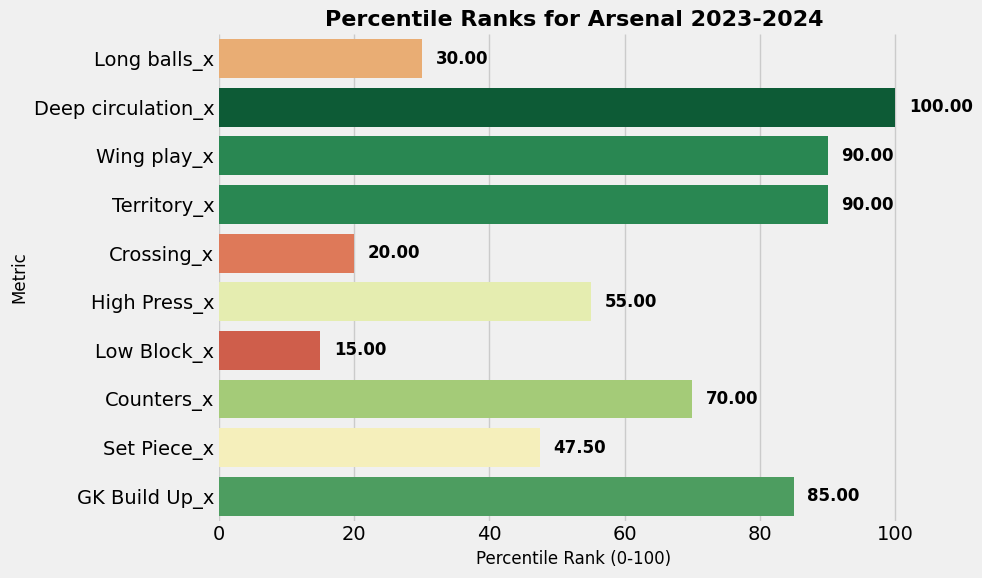

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Load the mapping file (Replace with your actual file path)
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'
mapping_df = pd.read_excel(mapping_file_path)

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

# Assuming final_result contains the aggregated data
final_result.columns = final_result.columns.str.strip()  # Clean column names

# Merge final_result with mapping_df to add the 'team' column
final_result['team'] = final_result['contestantId'].map(id_to_team)

# Filter for Ajax team
ajax_data = final_result[final_result['team'] == 'Chelsea']

if not ajax_data.empty:
    # List of columns to rank
    columns_to_rank = ['Long balls_x', 'Deep circulation_x', 'Wing play_x', 'Territory_x', 
                       'Crossing_x', 'High Press_x', 'Low Block_x', 'Counters_x', 'Set Piece_x', 'GK Build Up_x']

    # Check if columns exist
    missing_columns = [col for col in columns_to_rank if col not in ajax_data.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
    else:
        # Calculate percentile ranks (scale to 0-100) across all teams
        percentile_ranks = final_result[columns_to_rank].apply(lambda x: x.rank(pct=True) * 100, axis=0)

        # Extract percentile ranks for Ajax players
        ajax_percentiles = percentile_ranks[final_result['team'] == 'Chelsea'].mean()  # Take mean if multiple players

        # Define a red-green color gradient based on values
        norm = plt.Normalize(0, 100)
        colors = sns.color_palette("RdYlGn", as_cmap=True)(norm(ajax_percentiles.values))

        # Create a horizontal bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = sns.barplot(x=ajax_percentiles.values, y=ajax_percentiles.index, palette=colors, ax=ax)

        # Add values at the end of bars
        for bar, value in zip(bars.patches, ajax_percentiles.values):
            ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, f"{value:.2f}", 
                    ha='left', va='center', fontsize=12, fontweight='bold')

        # Add titles and labels
        ax.set_title("Percentile Ranks for Arsenal 2023-2024", fontsize=16, fontweight='bold')
        ax.set_xlabel('Percentile Rank (0-100)', fontsize=12)
        ax.set_ylabel('Metric', fontsize=12)

        # Remove unnecessary chart borders for a cleaner look
        sns.despine(left=True, bottom=True)

        # Show the plot
        plt.tight_layout()
        plt.show()
else:
    print("No data found for Ajax.")


In [8]:
import pandas as pd
import os
from tqdm import tqdm

# Define root folder path
folder_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/"  # Root folder (with league subfolders)
output_file = "Coach 2024-2025.xlsx"

# Define goalkeeper-related actions
gk_actions = {
    'Goalkick': 124,
    'GK throw': 123,
    'Parried Safe': 173,
    'Parried Danger': 174,
    'Fingertip': 175,
    'Caught': 176,
    'Collected': 177,
    'Standing Goalkeeper': 178,
    'Diving': 179,
    'Stooping': 180,
    'Reaching': 181,
    'Hands': 182,
    'Feet': 183,
    'Scored': 186,
    'Saved': 187,
    'Missed': 188
}

# Collect all results here
all_results = []

# Recursively scan all subfolders
for root, _, files in os.walk(folder_path):
    for file_name in tqdm(files, desc=f"Processing files in {root}"):
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            df = pd.read_csv(file_path)

            # ➕ Add League column from folder name
            df['League'] = os.path.basename(os.path.dirname(file_path))

            type_cols = [col for col in df.columns if '/qualifierId' in col]
            df['endX'] = 0.0
            df['endY'] = 0.0
            qualifier_value_cols = {int(col.split('/')[1]): col for col in df.columns if 'qualifier' in col and 'value' in col}

            for index, row in df.iterrows():
                for j, type_col in enumerate(type_cols):
                    if row[type_col] == 140:
                        endx_col = qualifier_value_cols.get(j)
                        if endx_col:
                            df.at[index, 'endX'] = row[endx_col]
                    elif row[type_col] == 141:
                        endy_col = qualifier_value_cols.get(j)
                        if endy_col:
                            df.at[index, 'endY'] = row[endy_col]

            df['Set Piece'] = 0
            df['From Corner'] = 0
            df['Free Kick'] = 0
            df['Throw In'] = 0

            for index, row in df.iterrows():
                for j, type_col in enumerate(type_cols):
                    qualifier = row[type_col]
                    if qualifier == 24:
                        df.at[index, 'Set Piece'] = 1
                    elif qualifier == 25:
                        df.at[index, 'From Corner'] = 1
                    elif qualifier == 26:
                        df.at[index, 'Free Kick'] = 1
                    elif qualifier == 160:
                        df.at[index, 'Throw In'] = 1

            df['Set Piece'] = df.apply(
                lambda row: 1 if row['typeId'] in [13, 14, 15, 16] and 
                            (row['Set Piece'] == 1 or row['From Corner'] == 1 or 
                             row['Free Kick'] == 1 or row['Throw In'] == 1) else 0,
                axis=1
            )

            df[['x', 'y', 'endX', 'endY']] = df[['x', 'y', 'endX', 'endY']].apply(pd.to_numeric, errors='coerce')

            df_long_balls = df[(df['typeId'] == 1) & (df['x'] < 30) & (df['endX'] > 50)]
            df_deep_circulations = df[(df['typeId'] == 1) & (df['x'].between(30, 60)) & (df['y'].between(22, 78)) & (df['endX'].between(30, 60))]
            df_wing_play = df[(df['typeId'] == 1) & (df['x'].between(30, 60)) & (df['y'].between(22, 78)) & ((df['endY'] < 22) | (df['endY'] > 78))]
            df_final_third = df[(df['typeId'] == 1) & (df['x'] > 70)]
            df_crossing = df[(df['typeId'] == 1) & (df['x'] > 50) & ((df['y'] <= 22) | (df['y'] >= 78)) & (df['endY'].between(22, 78)) & (df['endX'] > 85)]
            df_opposition_passes = df[df['typeId'] == 1]

            long_balls_count = df_long_balls.groupby('contestantId').size().reset_index(name='Long balls')
            deep_circulations_count = df_deep_circulations.groupby('contestantId').size().reset_index(name='Deep circulation')
            wing_play_count = df_wing_play.groupby('contestantId').size().reset_index(name='Wing play')
            final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')
            crossing_count = df_crossing.groupby('contestantId').size().reset_index(name='Crossing')
            total_final_third_passes = df_final_third.shape[0]
            final_third_count['Territory'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

            df['Low Block'] = df.apply(lambda row: 1 if row['typeId'] in [7, 8, 12] and row['x'] < 25 else 0, axis=1)
            total_defensive_actions = df[df['typeId'].isin([7, 8, 12])].shape[0]
            low_block_count = df.groupby('contestantId')['Low Block'].sum().reset_index()
            low_block_count['Low Block'] = (low_block_count['Low Block'] / total_defensive_actions) * 100

            def find_counters(df):
                counters = []
                for i in range(len(df)):
                    if df.iloc[i]['typeId'] == 49 and df.iloc[i]['x'] < 50:
                        found_counter = any(df.iloc[j]['typeId'] == 1 and df.iloc[j]['x'] > 70 for j in range(i + 1, min(i + 4, len(df))))
                        counters.append(1 if found_counter else 0)
                    else:
                        counters.append(0)
                return counters

            df['Counters'] = find_counters(df)
            counters_count = df.groupby('contestantId')['Counters'].sum().reset_index()

            result = long_balls_count.merge(deep_circulations_count, on='contestantId', how='left').fillna(0)
            result = result.merge(wing_play_count, on='contestantId', how='left').fillna(0)
            result = result.merge(final_third_count[['contestantId', 'Territory']], on='contestantId', how='left').fillna(0)
            result = result.merge(crossing_count, on='contestantId', how='left').fillna(0)
            result = result.merge(low_block_count, on='contestantId', how='left').fillna(0)
            result = result.merge(counters_count, on='contestantId', how='left').fillna(0)
            result = result.merge(df.groupby('contestantId')['Set Piece'].sum().reset_index(), on='contestantId', how='left').fillna(0)

            int_cols = ['Long balls', 'Deep circulation', 'Wing play', 'Crossing', 'Counters', 'Set Piece']
            result[int_cols] = result[int_cols].astype(int)

            for action in gk_actions.keys():
                df[action] = 0

            for i in range(len(df)):
                for col in type_cols:
                    qualifier_value = df.at[i, col]
                    for action, value in gk_actions.items():
                        if qualifier_value == value:
                            df.at[i, action] = 1

            df['GK_Action_Count'] = df[list(gk_actions.keys())].sum(axis=1)
            gk_candidates = df.groupby(['contestantId', 'playerName'])['GK_Action_Count'].sum().reset_index()
            gk_best_per_team = gk_candidates.sort_values(['contestantId', 'GK_Action_Count'], ascending=[True, False])
            gk_best_per_team = gk_best_per_team.groupby('contestantId').first().reset_index()

            gk_passes = df.merge(gk_best_per_team, on=['contestantId', 'playerName'], how='inner')
            gk_passes = gk_passes[gk_passes['typeId'] == 1]
            gk_pass_count = gk_passes.groupby(['contestantId', 'playerName']).size().reset_index(name='Pass_Count')
            total_passes = len(df[df['typeId'] == 1])
            gk_pass_count['GK Build Up'] = (gk_pass_count['Pass_Count'] / total_passes) * 100
            result = result.merge(gk_pass_count[['contestantId', 'playerName', 'Pass_Count', 'GK Build Up']], on='contestantId', how='left')

            # ➕ Add League column to final result
            result['League'] = df['League'].iloc[0]

            all_results.append(result)

# Combine all results
final_result = pd.concat(all_results, ignore_index=True)

# Averages per team
averages_per_contestant = final_result.groupby('contestantId').mean(numeric_only=True)

# Save to Excel
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, sheet_name='Aggregated Data', index=False)
    averages_per_contestant.to_excel(writer, sheet_name='Averages per Contestant', index=True)

print(f"✅ Processing completed. Results saved to '{output_file}'.")


Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/: 100%|█| 
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Portugal 2
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/La Liga 20
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/J1 2025: 1
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/La Liga II
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Serie A 20
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Czech 2024
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Belgian Fi
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Premier Le
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Denmark 20
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Austrian B
Processing files in /Users/marclambertes/Python/Matches/Men/2024-2025/Scotland 2
Processing files in /Users/m

✅ Processing completed. Results saved to 'Coach 2024-2025.xlsx'.
